# **Requirements**

Python 3.8.10

pythonnet 2.5.2

`pip install pythonnet==2.5.2`

In [ ]:
# Add this cell at the very top of the notebook (before: `from classes...`)
import sys
from pathlib import Path

project_root = Path.cwd().resolve().parent  # ...\FSO_Project
sys.path.insert(0, str(project_root))

print("Added to sys.path:", project_root)

Added to sys.path: D:\Msc.Photonics\Master Thesis\FSO_Project


In [1]:
from classes.base_interactive import PythonZOSConnection
from classes.beam_shaper import BeamShaperFitter, BeamShaper, EvenAsphere
import sys
from importlib import metadata
import numpy as np

print("Python version: ", sys.version)
print('Pythonnet version:', metadata.version('pythonnet'))

Python version:  3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Pythonnet version: 2.5.2


# **Connect to Zemax and initiate a system**

In [37]:
zos = PythonZOSConnection()
ZOSAPI = zos.ZOSAPI
TheApplication = zos.TheApplication
TheSystem = zos.TheSystem

# TheSystem.Mode = ZOSAPI.ZOSAPI_Mode.Plugin
TheSystem.UpdateMode = ZOSAPI.LensUpdateMode.AllWindows

print('Connected to OpticStudio')
# The connection should now be ready to use.  For example:
print('Serial #: ', TheApplication.SerialCode)

print('ZOSAPI Mode: ', TheSystem.Mode)
print("Lens update mode: ", TheSystem.UpdateMode)

SysExplore = TheSystem.SystemData
SysLDE = TheSystem.LDE
TheMFE = TheSystem.MFE

Connected to OpticStudio
Serial #:  20120530
ZOSAPI Mode:  0
Lens update mode:  2


In [2]:
galilean = BeamShaper(omega_0 = 2.366,
                  R_max=12.15,
                  r_max=4.05,
                  d=150,
                  n=1.46071,
                  type='Galilean'
                )

print("Vertex_radius_1:", galilean.r_c1)
print("Conic_constant_1:", galilean.k_1)
print("Vertex_radius_2:", galilean.r_c2)
print("Conic_constant_2:", galilean.k_2)


Vertex_radius_1: 11.017003283425508
Conic_constant_1: -30.692685297894425
Vertex_radius_2: 80.12350328342549
Conic_constant_2: -6.060545490862053


In [3]:
galileanfitter = BeamShaperFitter(galilean, num_samples=1000, sample_method="gaussian")

ea1 = EvenAsphere(r_max=galilean.r_max, vertex_r=galilean.r_c1, k=galilean.k_1, coefficients={4: 0.0, 6: 0.0}, num_samples=galileanfitter.num_samples)
ea2 = EvenAsphere(r_max=galilean.R_max, vertex_r=galilean.r_c2, k=galilean.k_2, coefficients={}, num_samples=galileanfitter.num_samples)

sag_fit = galileanfitter.ls_fit(ea1 = ea1, ea2 = ea2, compare=True)

sag_fit_s1 = sag_fit['surface1']
sag_fit_s2 = sag_fit['surface2']

s1_coeffs = sag_fit_s1['coefficients']
s2_coeffs = sag_fit_s2['coefficients']

print("sag fitting surface 1 vertex_radius=", sag_fit_s1['vertex_r'])
print("sag fitting surface 1 conic_constant=", sag_fit_s1['k'])

print("sag fitting surface 2 vertex_radius=", sag_fit_s2['vertex_r'])
print("sag fitting surface 2 conic_constant=", sag_fit_s2['k'])

print("Aspheric coefficients surface 1:", s1_coeffs)
print("Aspheric coefficients surface 2:", s2_coeffs)

print("rms", sag_fit['rms'])

d:\Msc.Photonics\Master Thesis\Beam_shaper\classes\beam_shaper.py:181: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(1 - (1 + self.k) * (self.r / self.vertex_r)**2)


ValueError: array must not contain infs or NaNs

In [40]:
dsag_fit = galileanfitter.ls_fit(ea1 = ea1, ea2 = ea2, fit_type='grad_sag')

dsag_fit_s1 = dsag_fit['surface1']
dsag_fit_s2 = dsag_fit['surface2']
print("dsag fitting surface 1 vertex_radius=", dsag_fit_s1['vertex_r'])
print("dsag fitting surface 1 conic_constant=", dsag_fit_s1['k'])

print("dsag fitting surface 2 vertex_radius=", dsag_fit_s2['vertex_r'])
print("dsag fitting surface 2 conic_constant=", dsag_fit_s2['k'])

print("rms", dsag_fit['rms'])

dsag fitting surface 1 vertex_radius= 10.67664200641646
dsag fitting surface 1 conic_constant= -29.54653494189052
dsag fitting surface 2 vertex_radius= 79.78314200641645
dsag fitting surface 2 conic_constant= -11.487893989913685
rms 0.0015114828836268659


# **Set System Data**

In [41]:
# Control variable for this chapter
RUN_SYSTEM_DATA = True  # Set to False to skip system data configuration

## **Set Title and Notes**

In [42]:
if RUN_SYSTEM_DATA:
    # Set Title and Notes
    SysExplore.TitleNotes.Title = "Galilean Beam Shaper"
    SysExplore.TitleNotes.Notes = "Galilean beam shaper design, turning a Gaussian into a flat-top beam."
    SysExplore.TitleNotes.Author = "Ziyi Xiong"

## **Set Aperture**

In [43]:
if RUN_SYSTEM_DATA:
    # Set Aperture
    SysExplore.Aperture.ApertureType = ZOSAPI.SystemData.ZemaxApertureType.EntrancePupilDiameter
    SysExplore.Aperture.ApertureValue = galilean.r_max * 2

    SysExplore.Aperture.ApodizationType = 1 # 0: Uniform, 1: Gaussian, 2: Cosine Cubed
    SysExplore.Aperture.ApodizationFactor = galilean.apodization_factor # Apodization factor for Gaussian

## **Set Fields**

In [44]:
if RUN_SYSTEM_DATA:
    # Set Fields
    SysExplore.Fields.SetFieldType(ZOSAPI.SystemData.FieldType.ParaxialImageHeight)
    #SysExplore.Fields.ApplyFieldWizard(ZOSAPI.SystemData.FieldPattern.EqualAreaY, 9, 6.6, 0, 0, 0, True, False)

## **Set Wavelengths**

### **Via Presets**

In [151]:
# SysExplore.Wavelengths.SelectWavelengthPreset(ZOSAPI.SystemData.WavelengthPreset.FdC_Visible)

### **Customize Wavelengths**

In [45]:
if RUN_SYSTEM_DATA:
    SysExplore.Wavelengths.GetWavelength(1).Wavelength = 0.532

### **Remove Wavelengths**

In [153]:
# if num_wavelengths > 1: [SysExplore.Wavelengths.RemoveWavelength(i) for i in range(num_wavelengths, 1, -1)]

# **Set Lens Data**

In [46]:
# Control variable for this chapter
RUN_LENS_DATA = True # Set to False to skip lens data configuration

if len(ea1.coefficients) > 0 or len(ea2.coefficients) > 0:
    FITTING= True

## **Add Surfaces**

In [47]:
if RUN_LENS_DATA:
    num_surfaces = SysLDE.NumberOfSurfaces

    if num_surfaces == 3:
        for i in range(5): # range(5) = [0, 1, 2, 3, 4]
            SysLDE.AddSurface()

    num_surfaces = SysLDE.NumberOfSurfaces
    print("Number of surfaces after insertion: ", num_surfaces)

Number of surfaces after insertion:  8


## **Get and Set Surfaces**

In [48]:
if RUN_LENS_DATA:
    # Use a list to store all surfaces objects
    Surface=[SysLDE.GetSurfaceAt(i) for i in range(0, num_surfaces)] 

## **Set Surface Data**

### **Set Stop**

In [49]:
if RUN_LENS_DATA:
    Surface[2].IsStop = True 

### **Set Lens Data**

In [50]:
if RUN_LENS_DATA:
    Surface[1].Thickness = 10
    Surface[1].Comment = "Dummy"

    Surface[2].Thickness = 3
    MaterialModel1 = Surface[2].MaterialCell.CreateSolveType(ZOSAPI.Editors.SolveType.MaterialModel)._S_MaterialModel
    MaterialModel1.IndexNd = galilean.n
    Surface[2].MaterialCell.SetSolveData(MaterialModel1)
    #Surface[2].SemiDiameter = galilean.r_max
    #Surface[2].MechanicalSemiDiameter = galilean.r_max

    Surface[3].Thickness = galilean.d
    Surface[3].Radius = galilean.r_c1
    Surface[3].Conic = galilean.k_1
    #Surface[3].SemiDiameter = galilean.r_max
    #Surface[3].MechanicalSemiDiameter = galilean.r_max

    Surface[5].Thickness = 3
    MaterialModel2 = Surface[5].MaterialCell.CreateSolveType(ZOSAPI.Editors.SolveType.MaterialModel)._S_MaterialModel
    MaterialModel2.IndexNd = galilean.n
    Surface[5].MaterialCell.SetSolveData(MaterialModel2)
    Surface[5].Radius = galilean.r_c2
    Surface[5].Conic = galilean.k_2
    
    Surface[6].Thickness = 10

In [51]:
if FITTING and RUN_LENS_DATA:
    EA = ZOSAPI.Editors.LDE.SurfaceType.EvenAspheric
    
    if len(ea1.coefficients) > 0:
        EA_set1 = SysLDE.GetSurfaceAt(3).GetSurfaceTypeSettings(EA)
        Surface[3].ChangeType(EA_set1)
        Surface[3].SurfaceData.Par2.DoubleValue = s1_coeffs[4]
        Surface[3].SurfaceData.Par3.DoubleValue = s1_coeffs[6]
        
    if len(ea2.coefficients) > 0:
        EA_set2 = SysLDE.GetSurfaceAt(5).GetSurfaceTypeSettings(EA)
        Surface[5].ChangeType(EA_set2)
        Surface[5].SurfaceData.Par2.DoubleValue = s2_coeffs[4]
        Surface[5].SurfaceData.Par3.DoubleValue = s2_coeffs[6]

In [52]:
#help(Surface[3])
#help(ZOSAPI.Editors.LDE.SurfaceType)

# **Optimization**

In [30]:
# Control variable for this chapter
RUN_OPTIMIZATION = True  # Set to True to enable optimization

## **Set Variables**

In [43]:
if RUN_OPTIMIZATION:
    Surface[3].RadiusCell.MakeSolveVariable()
    Surface[3].ConicCell.MakeSolveVariable()
    Surface[5].RadiusCell.MakeSolveVariable()
    Surface[5].ConicCell.MakeSolveVariable()
else:
    print("Optimization chapter skipped.")

## **Set Operands**

In [33]:
if RUN_OPTIMIZATION:
    # help(TheMFE)

    num_operands = TheMFE.NumberOfOperands
    #TheMFE.RemoveOperandsAt(1, num_operands)

In [32]:
if RUN_OPTIMIZATION:
    num_operands = TheMFE.NumberOfOperands

    num_samples = 101

    # num_samples = 101
    if num_operands == 1:
        for i in range(2 * num_samples):
            TheMFE.AddOperand()

    num_operands = TheMFE.NumberOfOperands

    print(num_operands)

    REAY = ZOSAPI.Editors.MFE.MeritOperandType.REAY
    REAB = ZOSAPI.Editors.MFE.MeritOperandType.REAB

203


In [445]:
if RUN_OPTIMIZATION:
    Operand_REAY = [TheMFE.GetOperandAt(i) for i in range(1, num_samples + 1)]

In [ ]:
if RUN_OPTIMIZATION:
    for i in range(len(Operand_REAY)):
        Operand_REAY[i].ChangeType(REAY)
        Operand_REAY[i].GetCellAt(2).IntegerValue =7
        # Operand_REAY[i].Weight = 50.0
        py = i / (num_samples - 1) 
        Operand_REAY[i].GetCellAt(7).DoubleValue = py
        r = galilean.r_max * py
        R = galilean.R_max * np.sqrt(1 - np.exp(-2 * (r / galilean.omega_0)**2)) / np.sqrt(1 - np.exp(-2 * (galilean.r_max / galilean.omega_0)**2))
        Operand_REAY[i].Target = R
        
if RUN_OPTIMIZATION:
    Operand_REAB = [TheMFE.GetOperandAt(i) for i in range(num_samples + 1, num_operands)]
    for i in range(len(Operand_REAB)):
        Operand_REAB[i].ChangeType(REAB)
        Operand_REAB[i].GetCellAt(2).IntegerValue = 7 # Number of surface
        Operand_REAB[i].Weight = 1.0
        py = i / (num_samples - 1)
        Operand_REAB[i].GetCellAt(7).DoubleValue = py
        Operand_REAB[i].Target = 0.0

Possible improvements:

1. Greater weights around center
2. Adjust Weights based on error
3. More sampling around the center??

In [34]:
'''
Only optimize the flat part 

For Galilean beam shaper, it seems impossible to have a flat top and wanted beam size at the same time when only  values are used.
'''
if RUN_OPTIMIZATION:
    Operand_REAY = [TheMFE.GetOperandAt(i) for i in range(1, num_samples + 1)]
    mid = 70 # 38 for k, s2: 41 for 4th, 47 for 6th; s1: 70 for 4th, 80 for 6th
    TheMFE.CalculateMeritFunction() # Must to get right error
    for i in range(0, mid):
        Operand_REAY[i].Weight = np.abs(Operand_REAY[i].Target - Operand_REAY[i].Value) * 10000.0 # adjust weights based on current error
 
    for i in range(mid, len(Operand_REAY)):
        Operand_REAY[i].Weight = np.abs(Operand_REAY[i].Target - Operand_REAY[i].Value) * 0.0

In [372]:
if RUN_OPTIMIZATION:
    EFFL = ZOSAPI.Editors.MFE.MeritOperandType.EFFL
    # TheMFE.AddOperand()
    Operand_EFFL = TheMFE.GetOperandAt(num_operands)
    Operand_EFFL.ChangeType(EFFL)
    Operand_EFFL.Target = 1e+10
    Operand_EFFL.Weight = 1

In [32]:
print(list(range(101, 101)))

[]


## **Optimize**

if RUN_OPTIMIZATION:
    run_localopt = input("Run local optimization? (y/n):")
    LocalOpt = TheSystem.Tools.OpenLocalOptimization()
    if run_localopt.lower() == 'y':
        LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
        LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Automatic
        LocalOpt.NumberOfCores = 16
        LocalOpt.RunAndWaitForCompletion()
        LocalOpt.Close()
    else:
        print("Optimization skipped.")

if RUN_OPTIMIZATION:
    run_hammeropt = input("Run Hammer optimization? (y/n):")
    HammerOpt = TheSystem.Tools.OpenHammerOptimization()
    if run_hammeropt.lower() == 'y':
        HammerOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
        HammerOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Automatic
        HammerOpt.NumberOfCores = 16
        HammerOpt.RunAndWaitForCompletion()
        HammerOpt.Close()
    else:
        print("Hammer optimization skipped.")

if RUN_OPTIMIZATION:
    HammerOpt = TheSystem.Tools.OpenHammerOptimization()
    help(TheSystem.Tools.OpenLocalOptimization())

if RUN_OPTIMIZATION:
    HammerOpt.MaxCores()

# **Analysis**

In [89]:
# Control variable for this chapter
RUN_ANALYSIS = True  # Set to False to skip analysis

In [90]:
if RUN_ANALYSIS:
    TheAna = TheSystem.Analyses
    num_analyses = TheAna.NumberOfAnalyses
    print(num_analyses)
    #help(TheAna)

2


In [91]:
if RUN_ANALYSIS:
    for i in range(1, num_analyses+1): 
        ana = TheAna.Get_AnalysisAtIndex(i)
        print(f"Analysis {i}: {ana.GetAnalysisName}")

Analysis 1: GeometricImageAnalysis
Analysis 2: OpticalPathFan


In [ ]:
if RUN_ANALYSIS:
    
    #TheAna.CloseAnalysis(1)

    #TheAna.CloseAnalysis(2)    
    #TheAna.New_GeometricImageAnalysis()

In [92]:
GeoImgAna1 = TheAna.Get_AnalysisAtIndex(1)
print(GeoImgAna1.GetAnalysisName)
#help(GeoImgAna)

GeometricImageAnalysis


## **Set and Apply Analyses**

In [50]:
if RUN_ANALYSIS:
    GIA_Settings1 = GeoImgAna1.GetSettings()
    help(GIA_Settings1)

Help on AS_GeometricImageAnalysis object:

class AS_GeometricImageAnalysis(ZemaxUI.ZOSAPI.Analysis.AS_Base)
 |  Void .ctor(ZemaxUI.ZOSAPI.Analysis.ZemaxAnalyses, ZOSAPI.Analysis.DataID)
 |  
 |  Method resolution order:
 |      AS_GeometricImageAnalysis
 |      ZemaxUI.ZOSAPI.Analysis.AS_Base
 |      ZemaxUI.Common.ViewModels.ZAPI_BaseObject
 |      System.MarshalByRefObject
 |      System.Object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature

In [51]:
if RUN_ANALYSIS:
    GIA_Settings1.Surface.SetSurfaceNumber(-1)
    print(GIA_Settings1.Surface.GetSurfaceNumber())
    #help(GIA_Settings1.Surface)

-1


In [52]:
if RUN_ANALYSIS:
    print(GIA_Settings1.RaysX1000)
    GIA_Settings1.RaysX1000 = 500000
    #help(GIA_Settings1.RaysX1000)

500000


In [53]:
if RUN_ANALYSIS:
    print(GIA_Settings1.ImageSize)
    GIA_Settings1.ImageSize = 32.0
    #help(GIA_Settings1.ImageSize)

32.0


In [19]:
if RUN_ANALYSIS:
    # ShowAsTypes: Surface, Contour, GreyScale, InverseGreyScale, FalseColor, InverseFalseColor, SpotDiagram, CrossX, CrossY
    GIA_Settings1.ShowAs = ZOSAPI.Analysis.GiaShowAsTypes.CrossX
    GIA_Settings1.get_ShowAs()

In [20]:
if RUN_ANALYSIS:
    GIA_Settings1.NumberOfPixels = 200

In [21]:
if RUN_ANALYSIS:
    GeoImgAna1.ApplyAndWaitForCompletion()

In [182]:
#GeoImgAna.Terminate()

## **Results**

In [95]:
if RUN_ANALYSIS:
    GIA_Results1 = GeoImgAna1.GetResults()
    #help(GIA_Results)

In [96]:
if RUN_ANALYSIS:
    print(GIA_Results1.NumberOfDataGrids)
    data1 = GIA_Results1.DataGrids[0]
    #help(data1)

1


40000
x: 200
y: 200


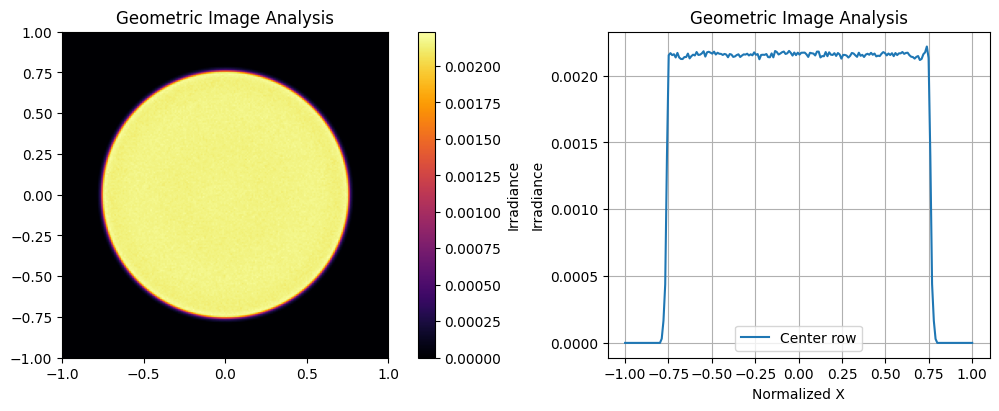

In [97]:
if RUN_ANALYSIS:
    #help(data1.Values)
    print(data1.Values.Length)
    print("x:", data1.Values.GetLength(0))
    print("y:", data1.Values.GetLength(1))
    zos.gia_plots(data1.Values, data1.Values.GetLength(0), data1.Values.GetLength(1), transpose=False)